In [1]:
from fourier_radiator import __path__ as src_path


In [2]:
src_path[0] + "/kernels/"

'/Users/caijie/Library/Mobile Documents/com~apple~CloudDocs/学术文档/研究工作/SimCode/fourier_radiator/src/fourier_radiator/kernels/'

In [3]:
from fourier_radiator import FourierRadiator

calc = FourierRadiator()

In [4]:
import hickle as hkl
import numpy as np
from tqdm.notebook import tqdm

# 加载数据
tracks = hkl.load('./tracks.hkl')

# 指定目标数据类型
target_dtype = np.float32  # 或 np.float64，根据需要选择

# 如果 tracks 是一个列表或元组的形式，我们可以直接转换其中的每个元素
for i, track in tqdm(enumerate(tracks), desc="Converting tracks to float32"):
    # 假设每个 track 是一个元组，包含多个数组
    tracks[i] = tuple(np.array(item, dtype=target_dtype) for item in track)

# 现在，tracks 中的所有数据都已经转换为 target_dtype

Converting tracks to float32: 0it [00:00, ?it/s]

In [5]:
from tqdm.notebook import tqdm
from synchrad.utils import r_e, omega_1m, alpha_fs
from scipy.constants import e, m_e, c, epsilon_0, hbar

Np = 1000       # Number of electrons
Num_osc = 4     # Number of oscillations
K0 = 20.0        # Undulator strength
particle_energy_MeV = 500
n_p = 8e18 * 1e6

gamma_0 = particle_energy_MeV * 1e6 * e / (m_e * c**2)
omega_p = c * ( 4 * np.pi * r_e * n_p)**0.5 
pz0 = (gamma_0**2 - 1)**.5
gamma_0m = (1 + pz0**2 + K0**2)**.5
omega_ch = omega_p / (2 * gamma_0m)**0.5
omega_ch_crit = 3/2 * K0 * gamma_0**2 * omega_ch

omega_ch = omega_p / (2 * gamma_0m)**0.5
lambda_ch = 2 * np.pi * c / omega_ch

# Simulation length and steps
L_ch =  Num_osc * lambda_ch
T_fin  = L_ch / c
Nt = L_ch / lambda_ch * 64

t_eval = np.r_[0: T_fin: 1j * Nt]
dt = t_eval[1] - t_eval[0]

In [6]:
calc_input = {
    "grid": [
        # (1e-3*omega_ch_crit/omega_1m, omega_ch_crit/omega_1m),  
        (1e-3*omega_ch_crit, omega_ch_crit),  
        (0, 2*K0/gamma_0),
        (0.0, 2 * np.pi),
        (512, 32, 32),
    ],  
}

omega_min, omega_max = calc_input["grid"][0]
theta_min, theta_max  = calc_input["grid"][1]
phi_min, phi_max = calc_input["grid"][2]
gridNodeNums = calc_input["grid"][3]
No, Nt, Np = gridNodeNums
# omega = np.r_[omega_min:omega_max:No*1j]
# theta = np.r_[theta_min:theta_max:Nt*1j]
omega = np.linspace(omega_min, omega_max, No, dtype=np.float32)
theta = np.linspace(theta_min, theta_max, Nt, dtype=np.float32)
phi = phi_min + (phi_max-phi_min)/Np*np.arange(Np, dtype=np.float32)

d_theta = (theta_max - theta_min) / (Nt - 1)
d_phi = (phi_max - phi_min) / (Np - 1)
d_omega = np.abs( omega[1:]-omega[:-1] )
d_V = d_theta * d_phi * d_omega

sinTheta = np.sin(theta)
cosTheta = np.cos(theta)
sinPhi = np.sin(phi)
cosPhi = np.cos(phi)

nSnaps = 1
ptnSteps = len(t_eval)
itSnaps = np.array([ptnSteps - 1], dtype=np.uint32)

In [7]:
nSteps = len(t_eval)
# 计算辐射谱
spectrum = calc.compute_radiation(tracks, omega, theta, phi, dt, nSteps, itSnaps, nSnaps)

Calculating spectrum: 100%|██████████| 1000/1000 [00:11<00:00, 86.45it/s]


In [9]:
import matplotlib.pyplot as plt

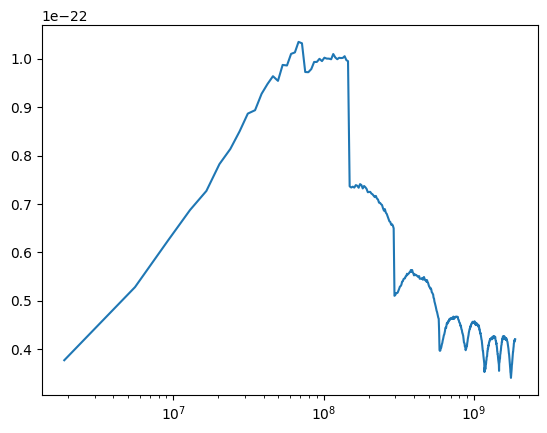

In [10]:
from scipy.constants import alpha as alpha_fs

val = spectrum[-1]

theta_loc = 0.5 * (theta[1:] + theta[:-1])
val_loc = 0.5 * (val[:,1:,:] + val[:,:-1,:])
int_theta = np.trapz( val_loc * np.sin(theta_loc)[None,:,None],
                                  theta_loc, axis=1)
val = d_phi * int_theta.sum(-1)
spect_ax_norm = omega * omega_1m/omega_ch_crit

plt.figure()
plt.plot(spect_ax_norm, val)
plt.xscale('log')

# plt.ylim([0, 1e8])
# plt.show()

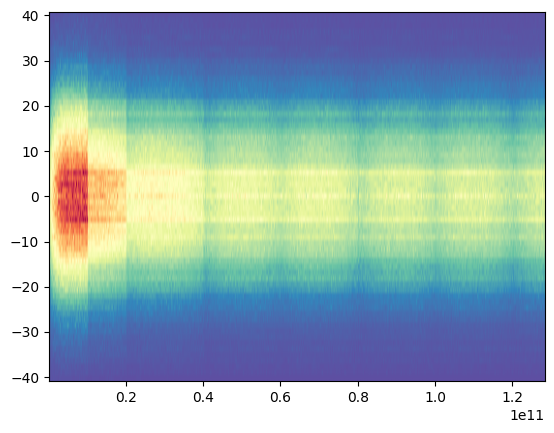

In [11]:
spect_val = spectrum[-1].astype(np.double)
spect_val = alpha_fs / (4 * np.pi**2) * spect_val
# spect_val /= total_weight
spect_val = np.c_[spect_val[:,:,spect_val.shape[2]//2-1][:,::-1], 
                  spect_val[:,1:,0]]

spect_ax_keV = omega  * 1.24e-6 * 1e-3
spect_ax_norm = omega * omega_1m/omega_ch_crit


extent = [spect_ax_keV.min(), 
          spect_ax_keV.max(), 
          -theta.max()* 1e3,
          theta.max()* 1e3 ]

plt.figure()

plt.imshow( spect_val.T,
            extent = extent,
            cmap=plt.cm.Spectral_r,
            origin='lower', 
           aspect='auto' )
plt.show()